## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [34]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.heatmap_analysis as heatmap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the pre-trained model

In [108]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)

(
    X_train,
    X_test,
    mdm2_y_train,
    mdm2_y_test,
    mdm2_y_raw_train,
    mdm2_y_raw_test,
    ca5_y_train,
    ca5_y_test,
    ca5_y_raw_train,
    ca5_y_raw_test,
    peptides_train,
    peptides_test,
) = train_test_split(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    test_size=0.2,
    shuffle=True,
    random_state=5,
)
mdm2_model = experiment.BinaryClassificationExperiment().train(
    X_train,
    mdm2_y_train,
    rnn.Joint_BinaryClassificationRNN_gelu,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # After initial training we are loading a pretrained model from memory
    load_trained_model=True,
    model_save_name="mdm2_bilstm_best.h5",
)
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5


def ca5_model(x):
    ca5_pred_raw = mdm2_model(x).numpy()
    ca5_pred_raw[:, 1] = 1 - ca5_pred_raw[:, 1]
    return ca5_pred_raw


ca5_y_pred_raw = ca5_model(X_test)
ca5_y_pred = ca5_y_pred_raw > 0.5


/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is -0.6565247891915524


In [109]:
print("MDM2")
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)


print('\n12ca5')
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred)

MDM2
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.8765533028122956
	 recall:  0.9933296275708727
	 # neg predictions:  467
	 # pos predictions:  6116

12ca5
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.9229122055674518
	 recall:  0.3634064080944351
	 # neg predictions:  6116
	 # pos predictions:  467


## 12ca5 Heatmaps From Ground Truth Good Sequences (No Model Training)

<AxesSubplot: >

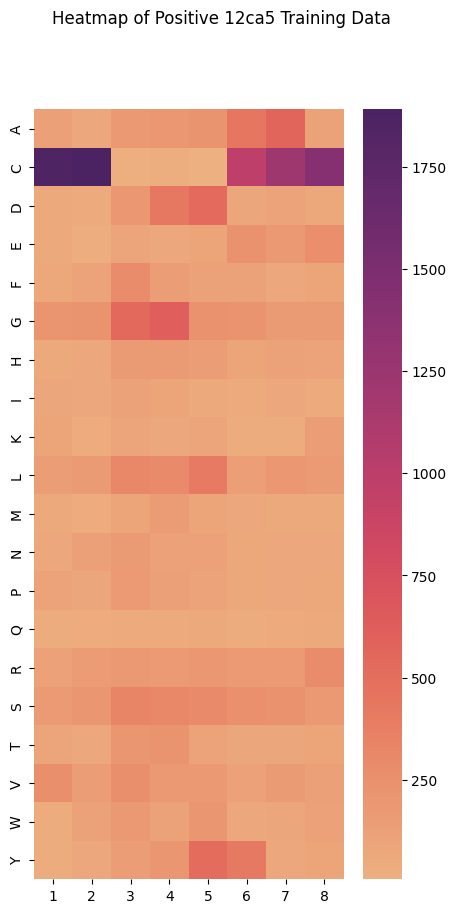

In [38]:
# TODO(Yehlin): WHy are we using the training dataset?
# Perhaps best to use either the full of the test dataset.
ca5_true_training_data_peptides = np.array(
    [peptide for idx, peptide in enumerate(peptides_train) if ca5_y_train[idx].all()]
)

heatmap.generate_heatmap(
    ca5_true_training_data_peptides, title="Heatmap of Positive 12ca5 Training Data"
)

In [8]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('ACV', 159),
 ('ALC', 162),
 ('DYS', 170),
 ('ACR', 180),
 ('LEC', 181),
 ('ACL', 189),
 ('AGC', 208),
 ('ASC', 214),
 ('ACS', 229),
 ('ACG', 237),
 ('AAC', 239),
 ('AVC', 265),
 ('YAC', 334),
 ('GDY', 550),
 ('DYA', 599)]

In [9]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 599)
('GDY', 550)
('YAC', 334)
('AVC', 265)
('AAC', 239)


## MDM2 vs 12ca5 From Ground Truth Good Sequences (No Model Training)

<AxesSubplot: >

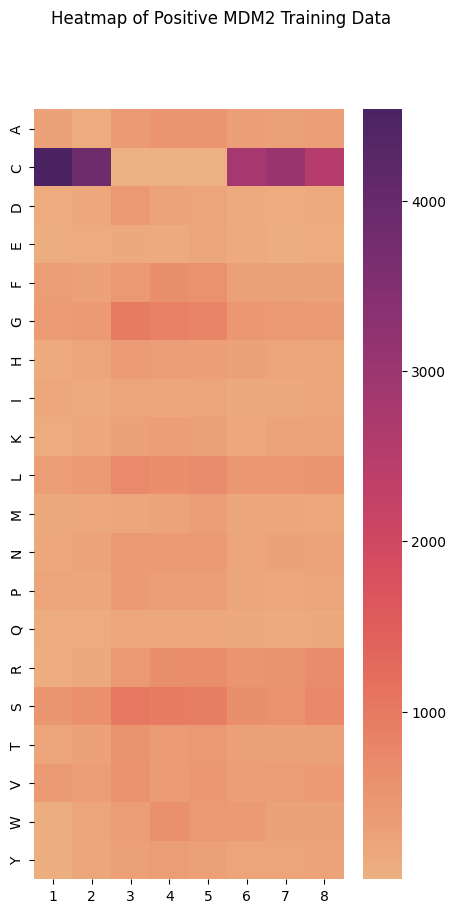

In [39]:
# TODO(Yehlin): WHy are we using the training dataset?
# Perhaps best to use either the full of the test dataset.
mdm2_true_training_data_peptides = np.array(
    [peptide for idx, peptide in enumerate(peptides_train) if mdm2_y_train[idx].all()]
)
heatmap.generate_heatmap(
    mdm2_true_training_data_peptides, title="Heatmap of Positive MDM2 Training Data"
)

In [13]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in mdm2_true_training_data_peptides]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]


In [ ]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('ACS', 675)
('ASC', 558)
('ACL', 487)
('ACG', 473)
('AVC', 435)


## 12ca5 Heatmaps from UMAP Cluster

In [6]:
embedding=umap.embedding_classification(mdm2_model,X)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


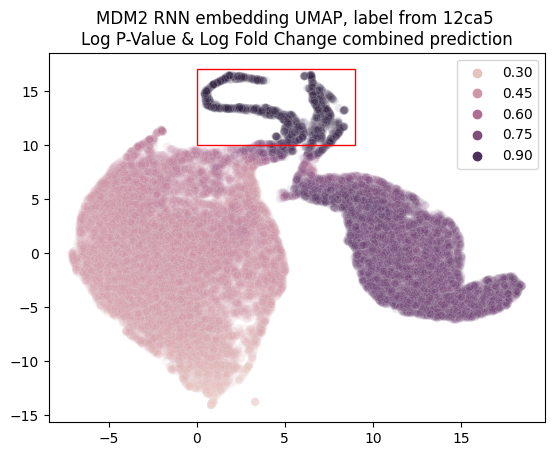

In [91]:
import matplotlib

ca5_coordinate = (0, 10)
ca5_width, ca5_height = 9, 7
ca5_rect = matplotlib.patches.Rectangle(
    ca5_coordinate, ca5_width, ca5_height, linewidth=1, edgecolor="r", facecolor="none"
)

umap.UMAP_vis(
    embedding,
    1 - mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from 12ca5 \nLog P-Value & Log Fold Change combined prediction",
    rectangle=ca5_rect,
)


In [111]:
def sample_in_bounds(emb, coor, w, h):
    return (emb[0] >= coor[0] and emb[0] <= (coor[0] + w)) and (
        emb[1] >= coor[1] and emb[1] <= (coor[1] + h)
    )


in_12ca5_cluster_peptides = [
    pep
    for idx, pep in enumerate(peptides)
    if sample_in_bounds(embedding[idx], coor=ca5_coordinate, w=ca5_width, h=ca5_height)
]
print('We have this many peptides in bounds for 12ca5:', len(in_12ca5_cluster_peptides))

# Print out some coordinates of embeddings in the box...
[
    emb
    for emb in embedding
    if sample_in_bounds(emb, coor=ca5_coordinate, w=ca5_width, h=ca5_height)
][:10]


We have this many peptides in bounds for 12ca5: 1836


[array([ 4.939644, 12.301557], dtype=float32),
 array([ 6.846732, 12.987245], dtype=float32),
 array([ 2.21652 , 13.310074], dtype=float32),
 array([ 0.961591, 15.572365], dtype=float32),
 array([ 6.0500603, 10.883329 ], dtype=float32),
 array([ 8.343   , 11.707325], dtype=float32),
 array([ 4.224946, 13.217004], dtype=float32),
 array([ 6.6655254, 14.033165 ], dtype=float32),
 array([ 7.4831977, 10.184261 ], dtype=float32),
 array([ 2.0675461, 16.420197 ], dtype=float32)]

<AxesSubplot: >

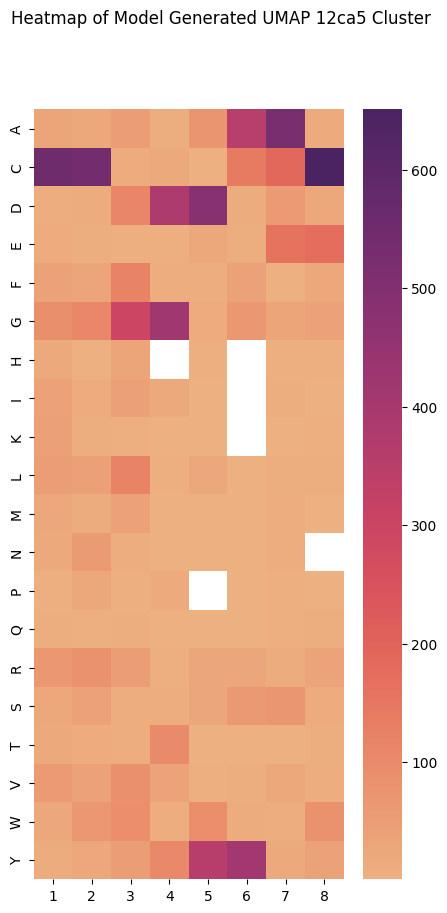

In [93]:
heatmap.generate_heatmap(
    in_12ca5_cluster_peptides, title="Heatmap of Model Generated UMAP 12ca5 Cluster"
)

In [76]:
ninemer_seq = []
for seq in in_12ca5_cluster_peptides:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in in_12ca5_cluster_peptides]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('AFC', 155)
('WCS', 106)
('FWC', 73)
('WFW', 62)
('FCD', 49)


## MDM2 Heatmaps from UMAP Cluster

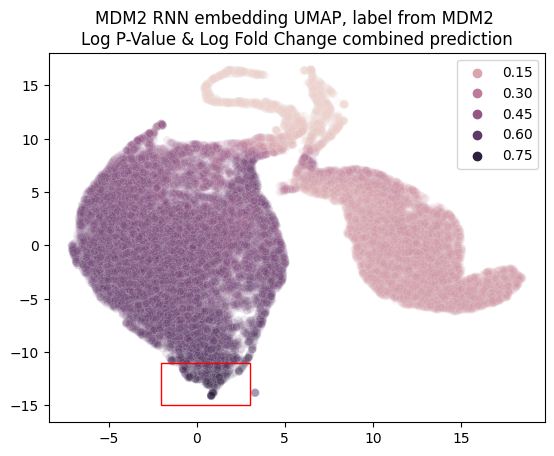

In [94]:
import matplotlib

mdm2_coordinate = (-2, -15)
mdm2_width, mdm2_height = 5, 4
rect = matplotlib.patches.Rectangle(
    mdm2_coordinate, mdm2_width, mdm2_height, linewidth=1, edgecolor="r", facecolor="none"
)

umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from MDM2 \nLog P-Value & Log Fold Change combined prediction",
    rectangle=rect,
)


cluster size:  517


<AxesSubplot: >

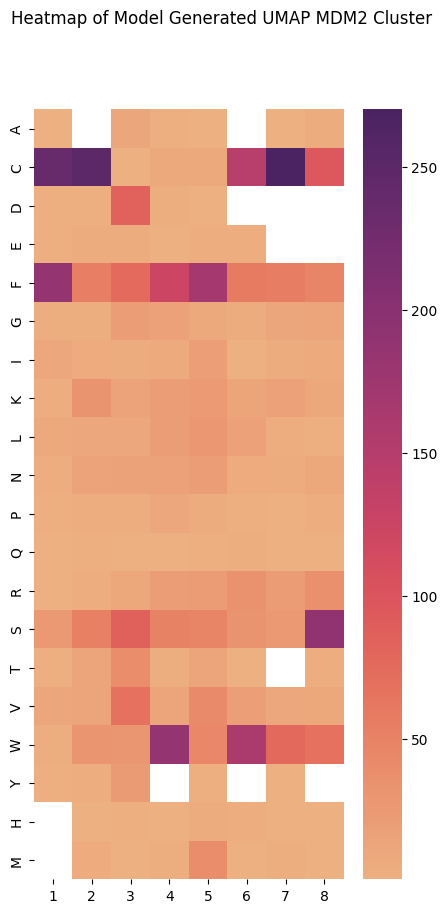

In [104]:
in_mdm2_cluster_peptides = [
    pep
    for idx, pep in enumerate(peptides)
    if sample_in_bounds(
        embedding[idx], coor=mdm2_coordinate, w=mdm2_width, h=mdm2_height
    )
]
print('cluster size: ', len(in_mdm2_cluster_peptides))
heatmap.generate_heatmap(
    in_mdm2_cluster_peptides, title="Heatmap of Model Generated UMAP MDM2 Cluster"
)


## 12ca5 Heatmaps from Model Ranking

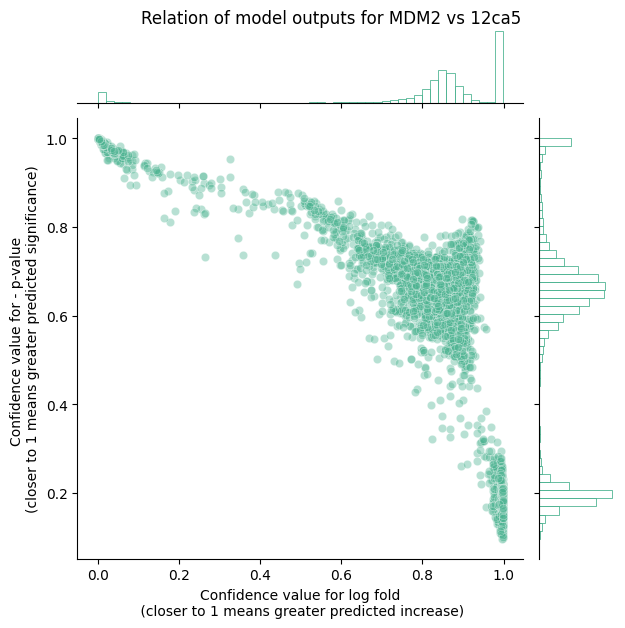

In [97]:
import matplotlib.pyplot as plt
import matplotlib


def show_volcano(y, protein_of_interest, other_protein, title, x_label, y_label):
    sns.set_palette(sns.color_palette("plasma"))
    p = sns.jointplot(
        x=y[:, 1],
        y=y[:, 0],
        color="#4CB391",
        alpha=0.4,
        marginal_kws=dict(bins=50, fill=False),
    )  
    p.fig.suptitle(title)
    p.set_axis_labels(x_label, y_label)
    p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 



show_volcano(
    mdm2_model(X_test),
    protein_of_interest,
    other_protein,
    title=f"Relation of model outputs for {protein_of_interest} vs {other_protein}",
    x_label="Confidence value for log fold\n (closer to 1 means greater predicted increase)",
    y_label="Confidence value for - p-value \n(closer to 1 means greater predicted significance)",
)


<AxesSubplot: >

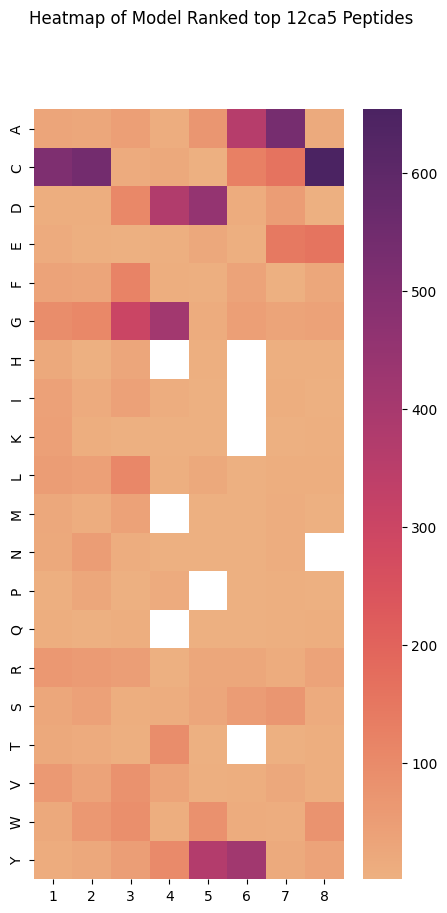

In [112]:
from analysis.hit_rate_analysis import sort_peptides_by_model_ranking

sorted_ca5_peptides = sort_peptides_by_model_ranking(
    peptides, ca5_model(X)
)
heatmap.generate_heatmap(
    sorted_ca5_peptides[:1800], title="Heatmap of Model Ranked top 12ca5 Peptides"
)

<AxesSubplot: >

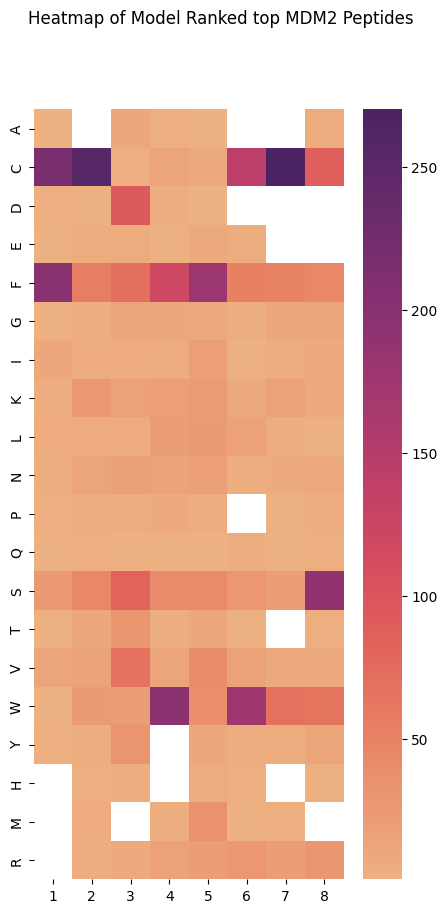

In [113]:
from analysis.hit_rate_analysis import sort_peptides_by_model_ranking

sorted_mdm2_peptides = sort_peptides_by_model_ranking(
    peptides, mdm2_model(X)
)
heatmap.generate_heatmap(
    sorted_mdm2_peptides[:500], title="Heatmap of Model Ranked top MDM2 Peptides"
)